# Задание 7. Кластеризация

Вам дана уже знакомая таблица данных в формате CSV,  данные в строчках разделены символом «точка-с-запятой». Файл создан департаментом сельского хозяйства США и в нём указаны продукты и содержание в них некоторых витаминов, минералов, а также калорийность на единицу массы.

## 0. Импорт библиотек, загрузка данных.

In [3]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, v_measure_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
#files.upload()
product_data = pd.read_csv('ABBREV.csv', delimiter=';')

In [5]:
product_data.head()

,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),...,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,1001,BUTTER.WITH SALT,15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,...,7.0,51.368,21.021,3.043,215,5.00,"1 pat. (1"" sq. 1/3"" high)",14.2,1 tbsp,0.0
1,1002,BUTTER.WHIPPED.W/ SALT,16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,...,4.6,45.390,19.874,3.331,225,3.80,"1 pat. (1"" sq. 1/3"" high)",9.4,1 tbsp,0.0
2,1003,BUTTER OIL.ANHYDROUS,0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,...,8.6,61.924,28.732,3.694,256,12.80,1 tbsp,205.0,1 cup,0.0
3,1004,CHEESE.BLUE,42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,...,2.4,18.669,7.778,0.800,75,28.35,1 oz,17.0,1 cubic inch,0.0
4,1005,CHEESE.BRICK,41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,...,2.5,18.764,8.598,0.784,94,132.00,1 cup. diced,113.0,1 cup. shredded,0.0


In [6]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NDB_No             8790 non-null   int64  
 1   Shrt_Desc          8790 non-null   object 
 2   Water_(g)          8790 non-null   float64
 3   Energ_Kcal         8790 non-null   int64  
 4   Protein_(g)        8790 non-null   float64
 5   Lipid_Tot_(g)      8790 non-null   float64
 6   Ash_(g)            8790 non-null   float64
 7   Carbohydrt_(g)     8790 non-null   float64
 8   Fiber_TD_(g)       8790 non-null   float64
 9   Sugar_Tot_(g)      8790 non-null   float64
 10  Calcium_(mg)       8790 non-null   int64  
 11  Iron_(mg)          8790 non-null   float64
 12  Magnesium_(mg)     8790 non-null   int64  
 13  Phosphorus_(mg)    8790 non-null   int64  
 14  Potassium_(mg)     8790 non-null   int64  
 15  Sodium_(mg)        8790 non-null   int64  
 16  Zinc_(mg)          8790 

Удалим текстовые колонки и колонку с пустыми значениями (можем позволить себе так сделать, потому что колонок и так много, а нужно просто посмотреть, как работает кластеризация).

In [7]:
product_data = product_data.drop(['Shrt_Desc', 'GmWt_Desc1', 'GmWt_Desc2', 'Refuse_Pct'], axis=1)

### Перевод заголовков.

'NDB_No'
'Shrt_Desc' - short description
'Water_(g)'
'Energ_Kcal'
'Protein_(g)' - белок
'Lipid_Tot_(g)' - lipid total, жир
'Ash_(g)' - any inorganic material? such as minerals? presenting in food
'Carbohydrt_(g)' - carbohydrate (carbs)
'Fiber_TD_(g)' - волокно, td=total?
'Sugar_Tot_(g)' - sugar total
'Calcium_(mg)'
'Iron_(mg)'
'Magnesium_(mg)' - магний
'Phosphorus_(mg)'
'Potassium_(mg)' - калий
'Sodium_(mg)' - натрий
'Zinc_(mg)'
'Copper_mg)' - медь
'Manganese_(mg)' - марганец
'Selenium_(µg)' - селен
'Vit_C_(mg)'
'Thiamin_(mg)'
'Riboflavin_(mg)'
'Niacin_(mg)'
'Panto_Acid_mg)'
'Vit_B6_(mg)'
'Folate_Tot_(µg)' - фолат
'Folic_Acid_(µg)' - фолиевая кислота
'Food_Folate_(µg)' - пищевой фолат
'Folate_DFE_(µg)' - folate Dietary Folate Equivalent
'Choline_Tot_ (mg)' - холин
'Vit_B12_(µg)'
'Vit_A_IU' - vitamin A International Units
'Vit_A_RAE' - vitamin A Retinol Activity Equivalent
'Retinol_(µg)'
'Alpha_Carot_(µg)'
'Beta_Carot_(µg)'
'Beta_Crypt_(µg)' - ?
'Lycopene_(µg)' - ликопин
'Lut+Zea_ (µg)' - ?
'Vit_E_(mg)'
'Vit_D_µg'
'Vit_D_IU'
'Vit_K_(µg)'
'FA_Sat_(g)' - saturated fat
'FA_Mono_(g)' - monosaturated fat
'FA_Poly_(g)' polysaturated fat
'Cholestrl_(mg)' - холестерин
'GmWt_1' - Gram Weight?
'GmWt_Desc1'
'GmWt_2'
'GmWt_Desc2'
'Refuse_Pct' - refuse persent?

## 1. Произвести уменьшение размерности данных.

Посмотрим на корреляционную матрицу.

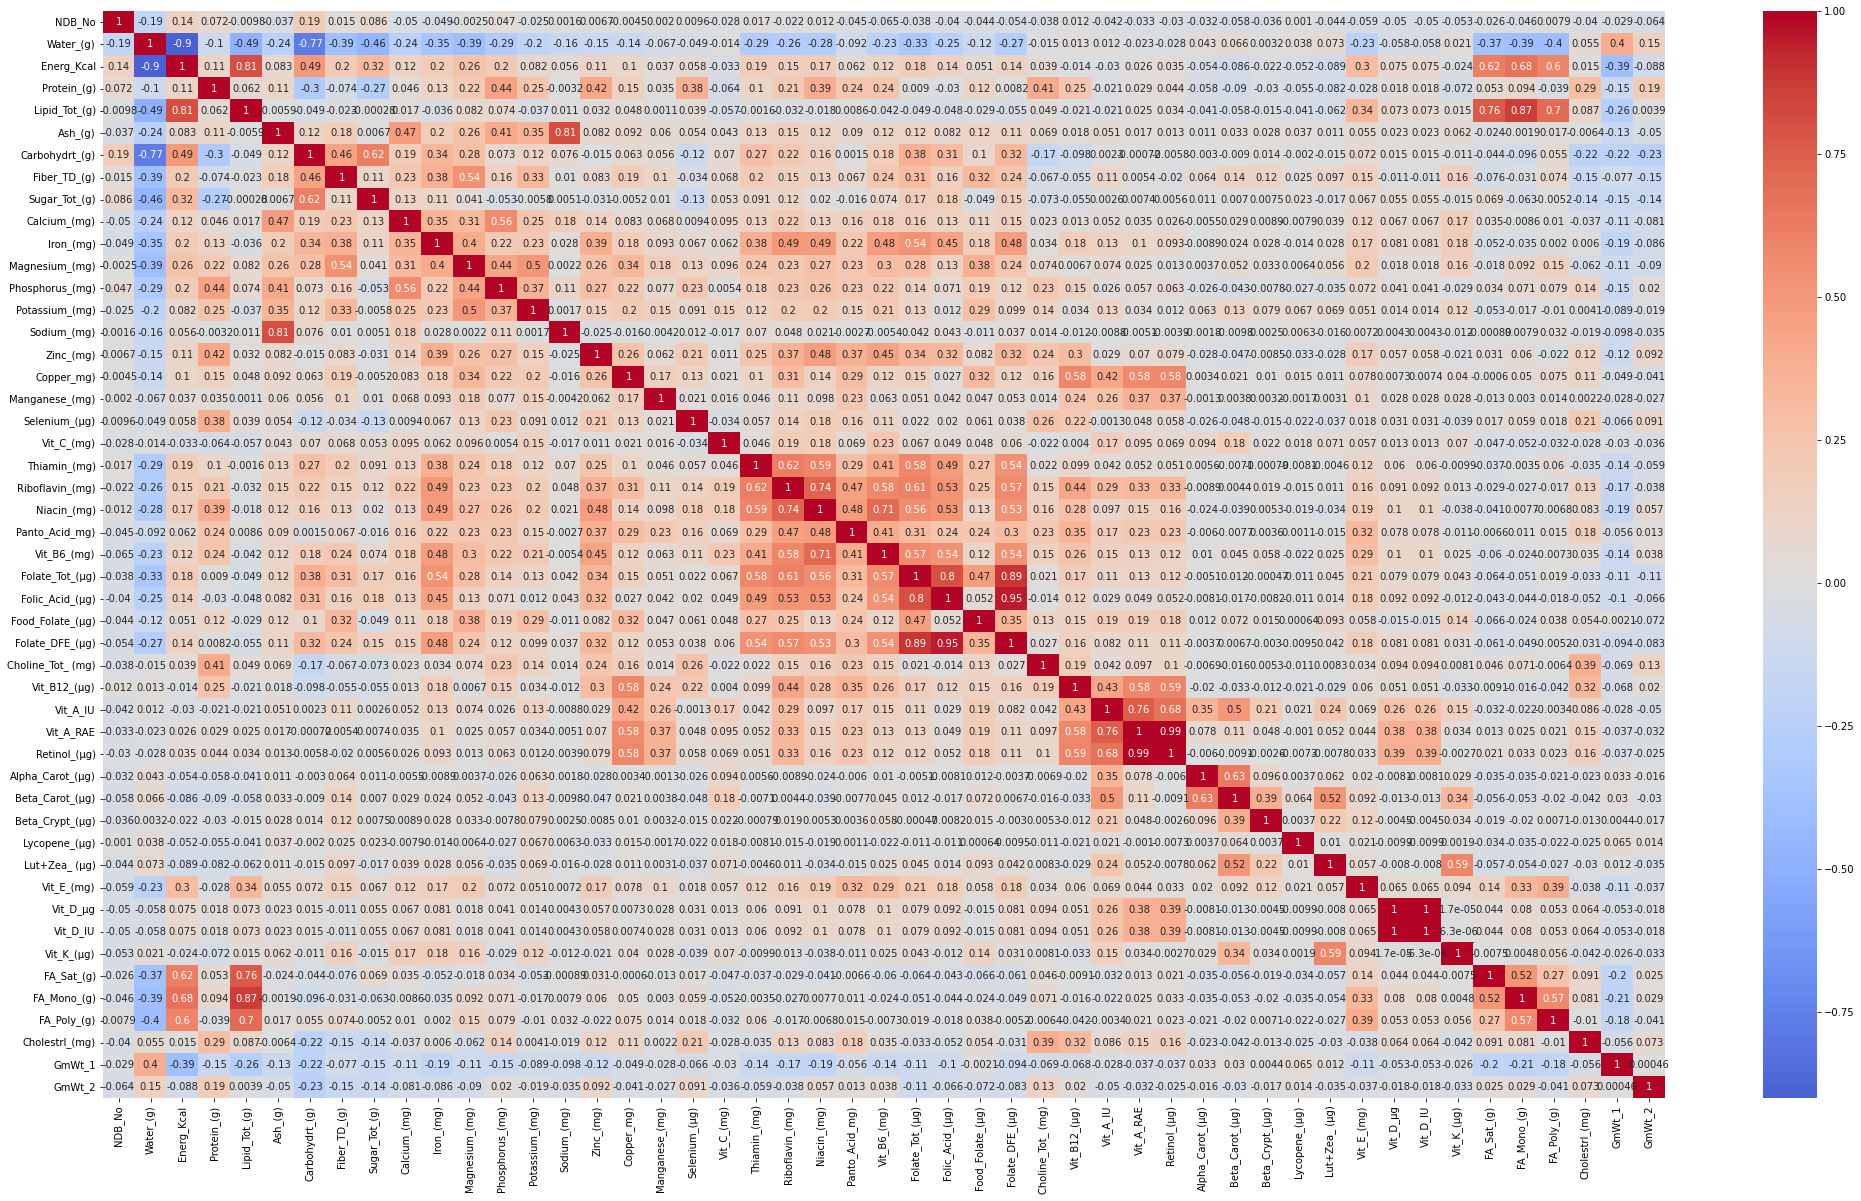

In [8]:
_, ax = plt.subplots(figsize=(35,20))
sns.heatmap(data=pd.DataFrame.corr(product_data), annot=True, cmap="coolwarm", center=0, ax=ax);

Оставим 2 колонки.

In [9]:
decreased_product_data = product_data[['Water_(g)', 'Energ_Kcal']]
decreased_product_data.head()

,Water_(g),Energ_Kcal
0,15.87,717
1,16.72,718
2,0.24,876
3,42.41,353
4,41.11,371


## 2. Кластеризовать данные как минимум двумя способами.

Будем использовать 2 метода - AgglomerativeClustering и KMeans с числом кластеров 5. Добавим соответствующие столбцы к датафрейму.

In [10]:
hierarchial_labels = AgglomerativeClustering(n_clusters=5).fit_predict(decreased_product_data)
kmeans_labels = KMeans(n_clusters=5, n_init=100, random_state=42).fit_predict(decreased_product_data)

labels_df = pd.DataFrame({'hierarchial_labels': hierarchial_labels, 'kmeans_labels': kmeans_labels})

decreased_product_data = decreased_product_data.join(labels_df)
display(decreased_product_data)

,Water_(g),Energ_Kcal,hierarchial_labels,kmeans_labels
0,15.87,717,2,2
1,16.72,718,2,2
2,0.24,876,4,2
3,42.41,353,1,1
4,41.11,371,1,1
...,...,...,...,...
8785,43.00,305,1,1
8786,70.25,111,0,0
8787,26.00,269,1,3
8788,79.20,90,0,0


## 3. Визуализировать результаты кластеризации.

Добавим к датасету разделение из 3 задания.

In [11]:
def creating_my_labels(x):
  if x['Energ_Kcal'] < 31:
    return 0
  elif x['Energ_Kcal'] < 71:
    return 1
  elif x['Energ_Kcal'] < 201:
    return 2
  elif x['Energ_Kcal'] < 401:
    return 3
  else:
    return 4

decreased_product_data['my_labels'] = decreased_product_data.apply(lambda y: creating_my_labels(y), axis=1)
decreased_product_data

,Water_(g),Energ_Kcal,hierarchial_labels,kmeans_labels,my_labels
0,15.87,717,2,2,4
1,16.72,718,2,2,4
2,0.24,876,4,2,4
3,42.41,353,1,1,3
4,41.11,371,1,1,3
...,...,...,...,...,...
8785,43.00,305,1,1,3
8786,70.25,111,0,0,2
8787,26.00,269,1,3,3
8788,79.20,90,0,0,2


Построим 3 графика.

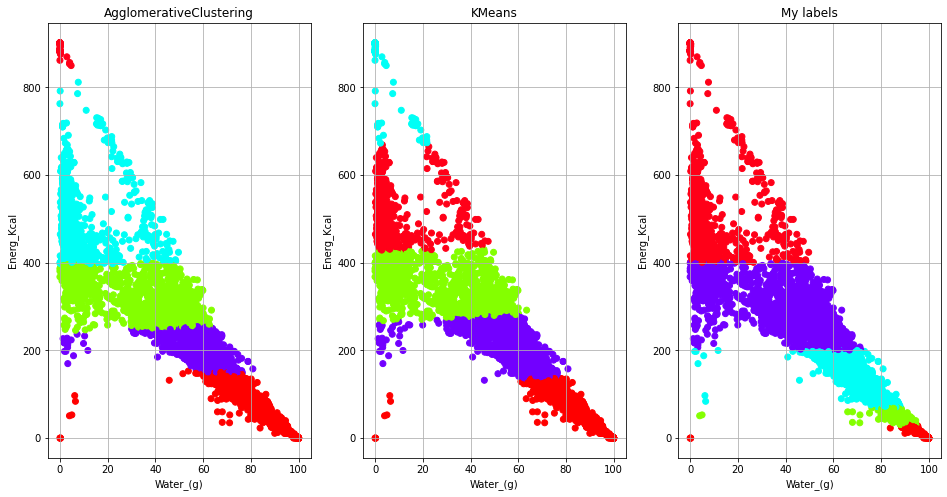

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))

ax1.scatter(decreased_product_data['Water_(g)'], decreased_product_data['Energ_Kcal'], c=decreased_product_data['hierarchial_labels'], cmap='hsv') 
ax1.grid(True)
ax1.set_title("AgglomerativeClustering")
ax1.set_xlabel("Water_(g)")
ax1.set_ylabel("Energ_Kcal");

ax2.scatter(decreased_product_data['Water_(g)'], decreased_product_data['Energ_Kcal'], c=decreased_product_data['kmeans_labels'], cmap='hsv')   
ax2.grid(True)
ax2.set_title("KMeans")
ax2.set_xlabel("Water_(g)")
ax2.set_ylabel("Energ_Kcal");

ax3.scatter(decreased_product_data['Water_(g)'], decreased_product_data['Energ_Kcal'], c=decreased_product_data['my_labels'], cmap='hsv')   
ax3.grid(True)
ax3.set_title("My labels")
ax3.set_xlabel("Water_(g)")
ax3.set_ylabel("Energ_Kcal");

## 4. Провести анализ полученных результатов, в том числе сравнить выбранные способы кластеризации.

In [13]:
silhouette_score_AC = silhouette_score(decreased_product_data[['Water_(g)', 'Energ_Kcal']], decreased_product_data['hierarchial_labels'])
silhouette_score_KM = silhouette_score(decreased_product_data[['Water_(g)', 'Energ_Kcal']], decreased_product_data['kmeans_labels'])

v_measure_score_AC = v_measure_score(decreased_product_data['hierarchial_labels'], decreased_product_data['my_labels'])
v_measure_score_KM = v_measure_score(decreased_product_data['kmeans_labels'], decreased_product_data['my_labels'])

metrics_df = pd.DataFrame({'silhouette score': [silhouette_score_AC, silhouette_score_KM], 
                                'v-score': [v_measure_score_AC, v_measure_score_KM]},
                               index=['AgglomerativeClustering', 'KMeans'])
display(metrics_df)

,silhouette score,v-score
AgglomerativeClustering,0.517434,0.623326
KMeans,0.561166,0.561943


Если рассматривать как кластеры без идеального разбиения, то лучше KMeans. Если в качестве идеального разбиения взять мое, то лучше AgglomerativeClustering.

## 5*. Подобрать способ уменьшения размерности для лучшего результата кластеризации.

Трансформируем датасет с помощью PCA и с помощью t-SNE, получим 2 массива размером 8790*2.

In [14]:
tsne_transformed_df = TSNE(n_components=2, random_state=42).fit_transform(product_data)
pca_transformed_df = PCA(n_components=2).fit_transform(product_data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [15]:
silhouette_score_tsne_AC, silhouette_score_pca_AC, silhouette_score_tsne_KM, silhouette_score_pca_KM = [], [], [], []
for i in range(2, 21):
    tsne_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(tsne_transformed_df)
    pca_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(pca_transformed_df)
    tsne_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(tsne_transformed_df)
    pca_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(pca_transformed_df)
    
    silhouette_score_tsne_AC.append(silhouette_score(tsne_transformed_df, tsne_hierarchial_labels))
    silhouette_score_pca_AC.append(silhouette_score(pca_transformed_df, pca_hierarchial_labels))
    silhouette_score_tsne_KM.append(silhouette_score(tsne_transformed_df, tsne_kmeans_labels))
    silhouette_score_pca_KM.append(silhouette_score(pca_transformed_df, pca_kmeans_labels))

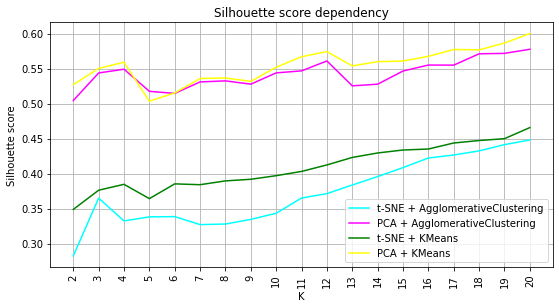

In [16]:
plt.figure(figsize=(9, 4.5))
plt.plot(range(2, 21), silhouette_score_tsne_AC, color='cyan', label='t-SNE + AgglomerativeClustering')
plt.plot(range(2, 21), silhouette_score_pca_AC, color='magenta', label='PCA + AgglomerativeClustering')
plt.plot(range(2, 21), silhouette_score_tsne_KM, color='green', label='t-SNE + KMeans')
plt.plot(range(2, 21), silhouette_score_pca_KM, color='yellow', label='PCA + KMeans')
#plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
plt.title('Silhouette score dependency')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.xticks(range(2, 21), rotation='vertical')
plt.legend(loc='lower right')                 
plt.show()

С увеличением числа кластеров качество улучшается. В большинстве рассмотренных случаев лучше всех справляется PCA в сочетании с KMeans. 

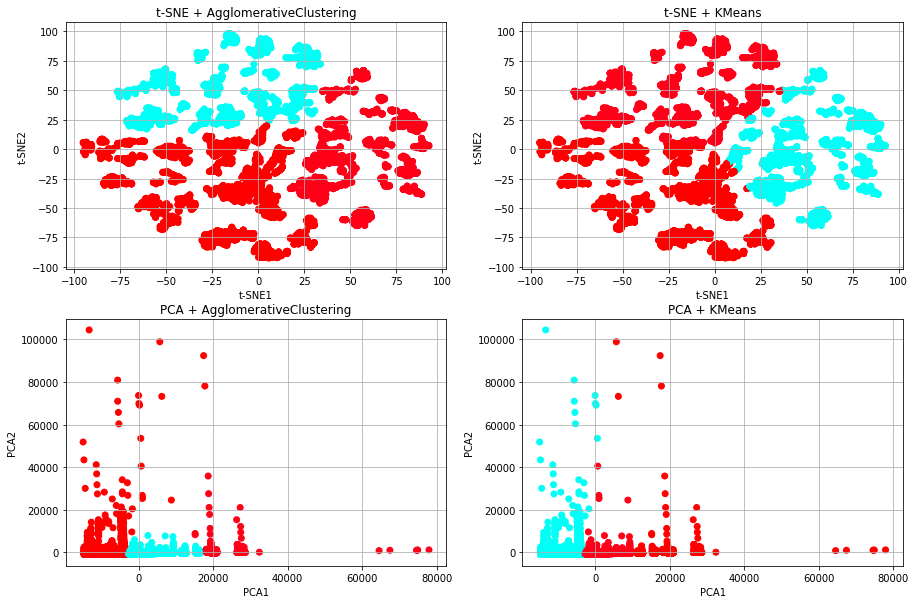

In [22]:
i = 3

tsne_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(tsne_transformed_df)
pca_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(pca_transformed_df)
tsne_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(tsne_transformed_df)
pca_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(pca_transformed_df)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(tsne_transformed_df[:, 0], tsne_transformed_df[:, 1], c=tsne_hierarchial_labels, cmap='hsv') 
axes[0, 0].grid(True)
axes[0, 0].set_title("t-SNE + AgglomerativeClustering")
axes[0, 0].set_xlabel("t-SNE1")
axes[0, 0].set_ylabel("t-SNE2");

axes[0, 1].scatter(tsne_transformed_df[:, 0], tsne_transformed_df[:, 1], c=tsne_kmeans_labels, cmap='hsv')   
axes[0, 1].grid(True)
axes[0, 1].set_title("t-SNE + KMeans")
axes[0, 1].set_xlabel("t-SNE1")
axes[0, 1].set_ylabel("t-SNE2");

axes[1, 0].scatter(pca_transformed_df[:, 0], pca_transformed_df[:, 1], c=pca_hierarchial_labels, cmap='hsv') 
axes[1, 0].grid(True)
axes[1, 0].set_title("PCA + AgglomerativeClustering")
axes[1, 0].set_xlabel("PCA1")
axes[1, 0].set_ylabel("PCA2");

axes[1, 1].scatter(pca_transformed_df[:, 0], pca_transformed_df[:, 1], c=pca_kmeans_labels, cmap='hsv')   
axes[1, 1].grid(True)
axes[1, 1].set_title("PCA + KMeans")
axes[1, 1].set_xlabel("PCA1")
axes[1, 1].set_ylabel("PCA2");

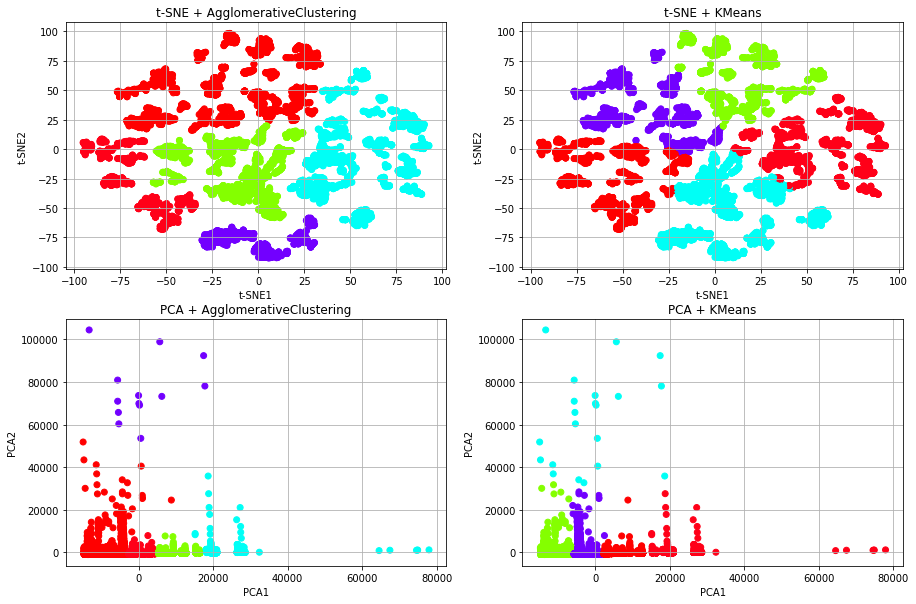

In [23]:
i = 5

tsne_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(tsne_transformed_df)
pca_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(pca_transformed_df)
tsne_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(tsne_transformed_df)
pca_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(pca_transformed_df)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(tsne_transformed_df[:, 0], tsne_transformed_df[:, 1], c=tsne_hierarchial_labels, cmap='hsv') 
axes[0, 0].grid(True)
axes[0, 0].set_title("t-SNE + AgglomerativeClustering")
axes[0, 0].set_xlabel("t-SNE1")
axes[0, 0].set_ylabel("t-SNE2");

axes[0, 1].scatter(tsne_transformed_df[:, 0], tsne_transformed_df[:, 1], c=tsne_kmeans_labels, cmap='hsv')   
axes[0, 1].grid(True)
axes[0, 1].set_title("t-SNE + KMeans")
axes[0, 1].set_xlabel("t-SNE1")
axes[0, 1].set_ylabel("t-SNE2");

axes[1, 0].scatter(pca_transformed_df[:, 0], pca_transformed_df[:, 1], c=pca_hierarchial_labels, cmap='hsv') 
axes[1, 0].grid(True)
axes[1, 0].set_title("PCA + AgglomerativeClustering")
axes[1, 0].set_xlabel("PCA1")
axes[1, 0].set_ylabel("PCA2");

axes[1, 1].scatter(pca_transformed_df[:, 0], pca_transformed_df[:, 1], c=pca_kmeans_labels, cmap='hsv')   
axes[1, 1].grid(True)
axes[1, 1].set_title("PCA + KMeans")
axes[1, 1].set_xlabel("PCA1")
axes[1, 1].set_ylabel("PCA2");

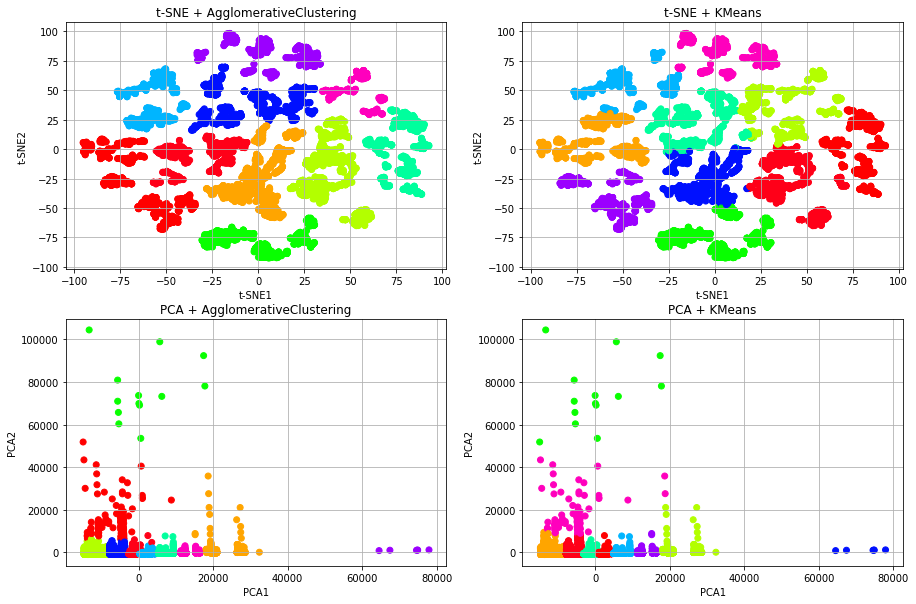

In [24]:
i = 10

tsne_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(tsne_transformed_df)
pca_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(pca_transformed_df)
tsne_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(tsne_transformed_df)
pca_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(pca_transformed_df)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(tsne_transformed_df[:, 0], tsne_transformed_df[:, 1], c=tsne_hierarchial_labels, cmap='hsv') 
axes[0, 0].grid(True)
axes[0, 0].set_title("t-SNE + AgglomerativeClustering")
axes[0, 0].set_xlabel("t-SNE1")
axes[0, 0].set_ylabel("t-SNE2");

axes[0, 1].scatter(tsne_transformed_df[:, 0], tsne_transformed_df[:, 1], c=tsne_kmeans_labels, cmap='hsv')   
axes[0, 1].grid(True)
axes[0, 1].set_title("t-SNE + KMeans")
axes[0, 1].set_xlabel("t-SNE1")
axes[0, 1].set_ylabel("t-SNE2");

axes[1, 0].scatter(pca_transformed_df[:, 0], pca_transformed_df[:, 1], c=pca_hierarchial_labels, cmap='hsv') 
axes[1, 0].grid(True)
axes[1, 0].set_title("PCA + AgglomerativeClustering")
axes[1, 0].set_xlabel("PCA1")
axes[1, 0].set_ylabel("PCA2");

axes[1, 1].scatter(pca_transformed_df[:, 0], pca_transformed_df[:, 1], c=pca_kmeans_labels, cmap='hsv')   
axes[1, 1].grid(True)
axes[1, 1].set_title("PCA + KMeans")
axes[1, 1].set_xlabel("PCA1")
axes[1, 1].set_ylabel("PCA2");

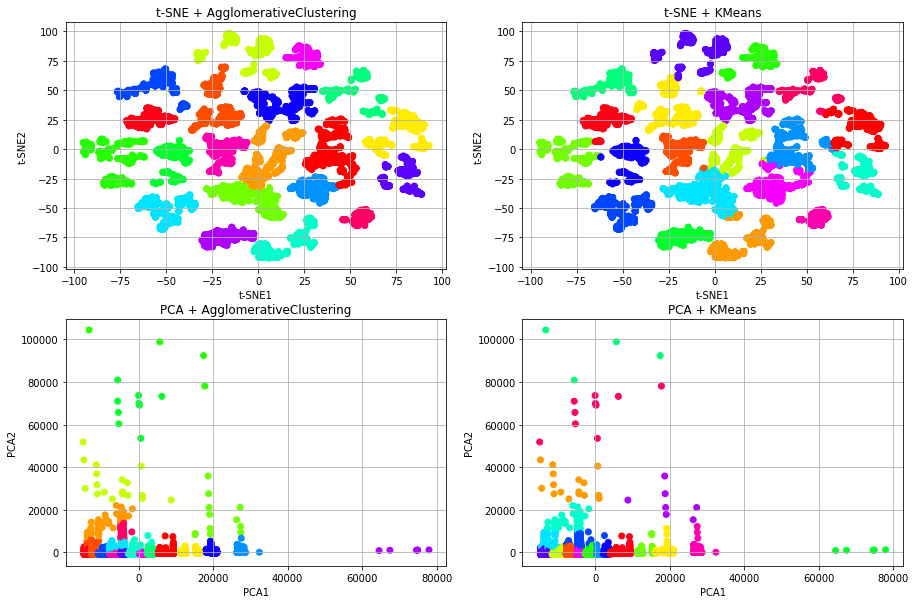

In [25]:
i = 20

tsne_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(tsne_transformed_df)
pca_hierarchial_labels = AgglomerativeClustering(n_clusters=i).fit_predict(pca_transformed_df)
tsne_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(tsne_transformed_df)
pca_kmeans_labels = KMeans(n_clusters=i, n_init=100, random_state=42).fit_predict(pca_transformed_df)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(tsne_transformed_df[:, 0], tsne_transformed_df[:, 1], c=tsne_hierarchial_labels, cmap='hsv') 
axes[0, 0].grid(True)
axes[0, 0].set_title("t-SNE + AgglomerativeClustering")
axes[0, 0].set_xlabel("t-SNE1")
axes[0, 0].set_ylabel("t-SNE2");

axes[0, 1].scatter(tsne_transformed_df[:, 0], tsne_transformed_df[:, 1], c=tsne_kmeans_labels, cmap='hsv')   
axes[0, 1].grid(True)
axes[0, 1].set_title("t-SNE + KMeans")
axes[0, 1].set_xlabel("t-SNE1")
axes[0, 1].set_ylabel("t-SNE2");

axes[1, 0].scatter(pca_transformed_df[:, 0], pca_transformed_df[:, 1], c=pca_hierarchial_labels, cmap='hsv') 
axes[1, 0].grid(True)
axes[1, 0].set_title("PCA + AgglomerativeClustering")
axes[1, 0].set_xlabel("PCA1")
axes[1, 0].set_ylabel("PCA2");

axes[1, 1].scatter(pca_transformed_df[:, 0], pca_transformed_df[:, 1], c=pca_kmeans_labels, cmap='hsv')   
axes[1, 1].grid(True)
axes[1, 1].set_title("PCA + KMeans")
axes[1, 1].set_xlabel("PCA1")
axes[1, 1].set_ylabel("PCA2");